# How To Quickly Compute The Mandelbrot Set In Python

## An experiment with parallelism and gpu computing using Numpy, Numexpr, Numba, Cython, PyOpenGL, and PyCUDA.

### Copied and slightly adapted from Jean Francois Puget:
* [Jean Francois Puget, "Mandelbrot Set Computation In Python"](https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en)
* [Jean Francois Puget, "How To Quickly Compute The Mandelbrot Set In Python"](https://www.ibm.com/developerworks/community/blogs/jfp/entry/How_To_Compute_Mandelbrodt_Set_Quickly?lang=en)
* [Cyril Rossant, "Accelerating Python code with Cython"](https://github.com/ipython-books/cookbook-2nd-code/blob/master/chapter05_hpc/05_cython.ipynb)

Let's import some useful packages first.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline

# Display

In order to check code correctness we will display the images.  

The display code is taken from [How To Make Python Run As Fast As Julia.](https://www.ibm.com/developerworks/community/blogs/jfp/entry/Python_Meets_Julia_Micro_Performance?lang=en)

We use small image sizes to enable quick check on all code, including the slowest ones.

In [2]:
params1 = (-2.0,0.5,-1.25,1.25),{"maxiter": 80}
params2 = (-0.74877,-0.74872,0.06505,0.06510),{"maxiter": 2048}
width=500
height=500

In [3]:
def mandelbrot_image(xmin,xmax,ymin,ymax,width=3,height=3,maxiter=80,cmap='hot'):
    dpi = 72
    img_width = dpi * width
    img_height = dpi * height
    x,y,z = mandelbrot_set(xmin,xmax,ymin,ymax,img_width,img_height,maxiter)
    
    fig, ax = plt.subplots(figsize=(width, height),dpi=72)
    ticks = np.arange(0,img_width,3*dpi)
    x_ticks = xmin + (xmax-xmin)*ticks/img_width
    plt.xticks(ticks, x_ticks)
    y_ticks = ymin + (ymax-ymin)*ticks/img_width
    plt.yticks(ticks, y_ticks)
    
    norm = colors.PowerNorm(0.3)
    ax.imshow(z.T,cmap=cmap,origin='lower',norm=norm) 
    
from functools import partial
mandelbrot_image1 = partial(mandelbrot_image, *params1[0], **params1[1])
mandelbrot_image2 = partial(mandelbrot_image, *params2[0], **params2[1])

## Baseline

Let's set a base line, using code from [Julia GitHhub](https://github.com/JuliaLang/julia/blob/master/test/perf/micro/perf.py)

In [4]:
def mandelbrot(z,maxiter):
    c = z
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return maxiter

def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    return (r1,r2,[mandelbrot(complex(r, i),maxiter) for r in r1 for i in r2])

We use two images for the benchmark. For now, we only evaluate the faster one.

In [5]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])

1.11 s ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Numpy

Let's replace lists with Numpy arrays.

In [6]:
def mandelbrot(c,maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return 0

def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i] + 1j*r2[j],maxiter)
    return (r1,r2,n3)

In [7]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])

2.68 s ± 50.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's check these images are correct.  We check with a small size image given the code is really slow.

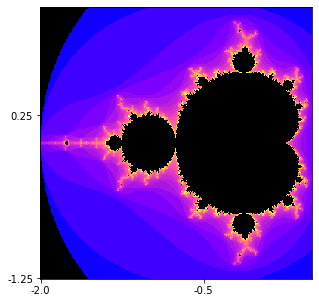

In [8]:
mandelbrot_image1(width=5,height=5,cmap='gnuplot2')

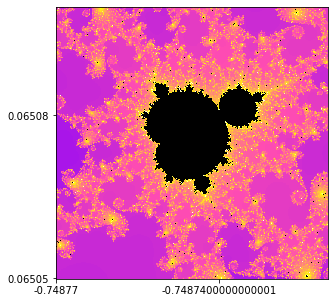

In [9]:
mandelbrot_image2(width=5,height=5,cmap='gnuplot2')

## Numba

Compiling code with Numba is easy, we simply need to annotate the functions with `@jit`.

In [10]:
from numba import jit

@jit
def mandelbrot(c,maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return 0

@jit
def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i] + 1j*r2[j],maxiter)
    return (r1,r2,n3)

Timing it shows it is pretty fast

In [11]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])
%timeit mandelbrot_set(*params2[0],width=width,height=height, **params2[1])

63.1 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.51 s ± 32.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Checking if it is correct

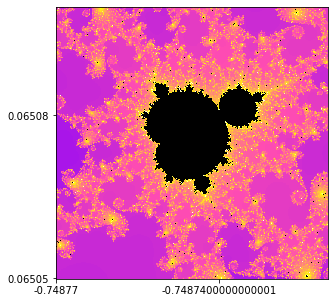

In [12]:
mandelbrot_image2(width=5,height=5,cmap='gnuplot2')

Removing square root computation within abs

In [13]:
@jit
def mandelbrot(c,maxiter):
    z = c
    for n in range(maxiter):
        if z.real * z.real + z.imag * z.imag > 4.0:
            return n
        z = z*z + c
    return 0

@jit
def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i] + 1j*r2[j],maxiter)
    return (r1,r2,n3)

It is faster.

In [14]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])
%timeit mandelbrot_set(*params2[0],width=width,height=height, **params2[1])

20.9 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
532 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Checking if it is correct

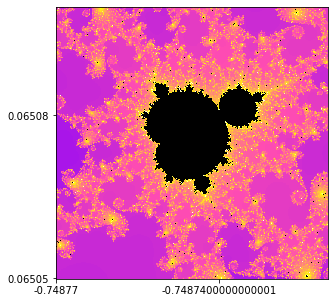

In [15]:
mandelbrot_image2(width=5,height=5,cmap='gnuplot2')

Decomposing complex into two floats.

In [16]:
@jit
def mandelbrot(creal,cimag,maxiter):
    real = creal
    imag = cimag
    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2* real*imag + cimag
        real = real2 - imag2 + creal       
    return 0


@jit
def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i],r2[j],maxiter)
    return (r1,r2,n3)

Slightly faster.

In [17]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])
%timeit mandelbrot_set(*params2[0],width=width,height=height, **params2[1])

21.1 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
529 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


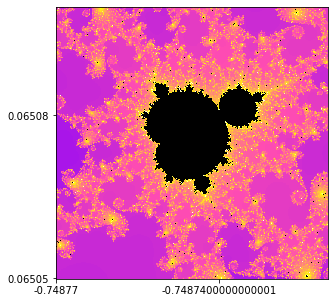

In [18]:
mandelbrot_image2(width=5,height=5,cmap='gnuplot2')

Code from http://numba.pydata.org/numba-doc/0.21.0/user/examples.html

In [19]:
@jit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    c = complex(x,y)
    z = 0j
    for i in range(max_iters):
        z = z*z + c
        if z.real * z.real + z.imag * z.imag > 4:
            return i

    return 0

@jit(nopython=True)
def create_fractal(min_x, max_x, min_y, max_y, width, height, maxiter):
    image = np.empty((width,height))
    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, maxiter)
            image[y, x] = color

    return image


A tad slower than mine.

In [20]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])
%timeit mandelbrot_set(*params2[0],width=width,height=height, **params2[1])

20.9 ms ± 435 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
528 ms ± 3.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Cython

In [21]:
%load_ext cython

In [22]:
%%cython -a
import cython
import numpy as np

def mandelbrot(creal, cimag, maxiter):
    real = creal
    imag = cimag
    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2* real*imag + cimag
        real = real2 - imag2 + creal;
    return 0

def mandelbrot_set(xmin, xmax, ymin, ymax, width, height, maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height), np.int32)    
    for i in range(width):
        for j in range(height):            
            n3[i,j] = mandelbrot(r1[i], r2[j], maxiter)     
    return (r1,r2,n3)

Without type annotations, very very slow

In [23]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])

3.03 s ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%cython -a
import cython
import numpy as np

cdef int mandelbrot(double creal, double cimag, int maxiter):
    cdef:
        double real2, imag2
        double real = creal, imag = cimag
        int n

    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2* real*imag + cimag
        real = real2 - imag2 + creal;
    return 0

def mandelbrot_set(xmin, xmax, ymin, ymax, width, height, maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height), np.int32)
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i], r2[j], maxiter)
     
    return (r1,r2,n3)

Annotating the inner function helps enormously

In [25]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])
%timeit mandelbrot_set(*params2[0],width=width,height=height, **params2[1])

79.8 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
576 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%%cython -a
import cython
import numpy as np

cdef int mandelbrot(double creal, double cimag, int maxiter):
    cdef:
        double real2, imag2
        double real = creal, imag = cimag
        int n

    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2* real*imag + cimag
        real = real2 - imag2 + creal;
    return 0

@cython.boundscheck(False) 
@cython.wraparound(False)
cpdef mandelbrot_set(double xmin, double xmax, double ymin, double ymax, int width, int height, int maxiter):
    cdef:
        double[:] r1 = np.linspace(xmin, xmax, width)
        double[:] r2 = np.linspace(ymin, ymax, height)
        int[:,:] n3 = np.empty((width,height), np.int32)
        int i,j
    
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i], r2[j], maxiter)
     
    return (r1,r2,n3)

Almost as fast as Numba

In [27]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])
%timeit mandelbrot_set(*params2[0],width=width,height=height, **params2[1])

19.7 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
510 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's check it

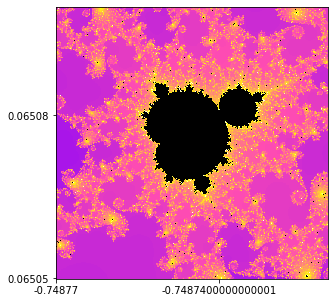

In [28]:
mandelbrot_image2(width=5,height=5,cmap='gnuplot2')

## Numpy array operations

Code from https://github.com/pyopencl/pyopencl/blob/master/examples/demo_mandelbrot.py

In [29]:
def mandelbrot_numpy(q, maxiter):
    # calculate z using numpy, this is the original
    # routine from vegaseat's URL
    output = np.resize(np.array(0,), q.shape)
    z = np.zeros(q.shape, np.complex64)
    for it in range(maxiter):
        z = z*z + q
        done = np.greater(abs(z), 2.0)
        q = np.where(done, 0+0j, q)
        z = np.where(done, 0+0j, z)
        output = np.where(done, it, output)
    return output

def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    q = np.ravel(r1 + r2[:,None]*1j)
    n3 = mandelbrot_numpy(q,maxiter)
    n3 = n3.reshape((width,height))
    return (r1,r2,n3.T)

In [30]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])

395 ms ± 29.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can check it is correct with the following.

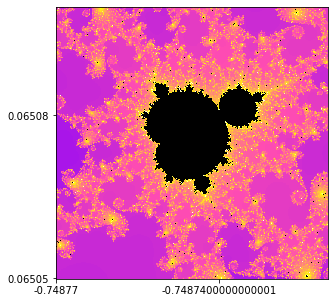

In [31]:
mandelbrot_image2(width=5,height=5,cmap='gnuplot2')

There is a better code from http://www.vallis.org/salon/summary-10.html

In [32]:
def mandelbrot_numpy(c, maxiter):
    output = np.zeros(c.shape)
    z = np.empty(c.shape, np.complex64)
    output[:] = maxiter
    for it in range(maxiter):
        notdone = (output == maxiter)
        z[notdone] = z[notdone]**2 + c[notdone]
        output[notdone & (z.real*z.real + z.imag*z.imag > 4.0)] = it
        
    return output

It is indeed way faster.

In [33]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in add
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in square
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


127 ms ± 3.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The code can be made faster by only performing computation where needed. There is no need to ravel the input array either.

In [34]:
def mandelbrot_numpy(c, maxiter):
    output = np.zeros(c.shape)
    z = np.zeros(c.shape, np.complex64)
    for it in range(maxiter):
        notdone = np.less(z.real*z.real + z.imag*z.imag, 4.0)
        output[notdone] = it
        z[notdone] = z[notdone]**2 + c[notdone]
    output[output == maxiter-1] = 0
    return output

def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    n3 = mandelbrot_numpy(c,maxiter)
    return (r1,r2,n3.T) 

It is about 3 times faster than the first Numpy array code.

In [35]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])
%timeit mandelbrot_set(*params2[0],width=width,height=height, **params2[1])

96.7 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.27 s ± 63.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can check it is correct with the following.

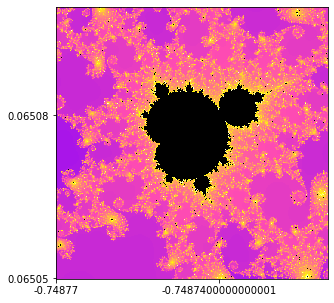

In [36]:
mandelbrot_image2(width=5,height=5,cmap='gnuplot2')

## Numexpr

We can avoid temporary array creation with NumExpr.

In [37]:
import numexpr as ne

def mandelbrot_numpy(c, maxiter):
    output = np.zeros(c.shape)
    z = np.zeros(c.shape, np.complex64)
    for it in range(maxiter):
        notdone = ne.evaluate('z.real*z.real + z.imag*z.imag < 4.0')
        output[notdone] = it
        z = ne.evaluate('where(notdone,z**2+c,z)')
    output[output == maxiter-1] = 0    
    return output

This is faster.

In [38]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])
%timeit mandelbrot_set(*params2[0],width=width,height=height, **params2[1])

98.9 ms ± 3.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.71 s ± 76.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check.

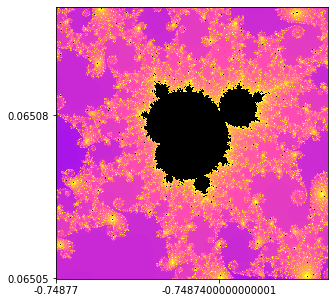

In [39]:
mandelbrot_image2(width=5,height=5,cmap='gnuplot2')

## Numba vectorize

An alternative to NumExpr.

In [40]:
from numba import vectorize, complex64, boolean, jit

@vectorize([boolean(complex64)])
def f(z):
    return (z.real*z.real + z.imag*z.imag) < 4.0

@vectorize([complex64(complex64, complex64)])
def g(z,c):
    return z*z + c 

@jit
def mandelbrot_numpy(c, maxiter):
    output = np.zeros(c.shape, np.int)
    z = np.empty(c.shape, np.complex64)
    for it in range(maxiter):
        notdone = f(z)
        output[notdone] = it
        z[notdone] = g(z[notdone],c[notdone]) 
    output[output == maxiter-1] = 0
    return output


def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = np.empty((r1.shape[0], r2.shape[0]), dtype=np.complex64)
    c[:,:] = r1 + r2[:,None]*1j
    n3 = mandelbrot_numpy(c,maxiter)
    return (r1,r2,n3.T) 

Even faster!

In [41]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])
%timeit mandelbrot_set(*params2[0],width=width,height=height, **params2[1])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in f


49.7 ms ± 3.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
662 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check.

**!!!Looks bad in the JupyterHub image!!!**

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in f


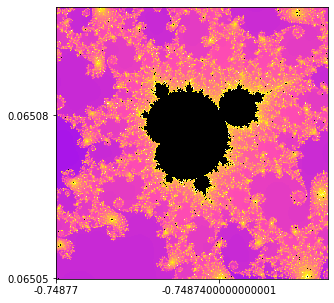

In [42]:
mandelbrot_image2(width=5,height=5,cmap='gnuplot2')

Try parallelism

In [43]:
from numba import vectorize, complex64, boolean

@vectorize([boolean(complex64)], target='parallel')
def f(z):
    return (z.real*z.real + z.imag*z.imag) < 4.0

@vectorize([complex64(complex64, complex64)], target='parallel')
def g(z,c):
    return z*z + c 

def mandelbrot_numpy(c, maxiter):
    output = np.empty(c.shape, np.int)
    z = np.zeros(c.shape, np.complex64)
    for it in range(maxiter):
        notdone = f(z)
        output[notdone] = it
        z[notdone] = g(z[notdone],c[notdone])   
    return output

Not paying off.

In [44]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])
%timeit mandelbrot_set(*params2[0],width=width,height=height, **params2[1])

78 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.81 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**!!!Looks strange in the JupyterHub image!!!**

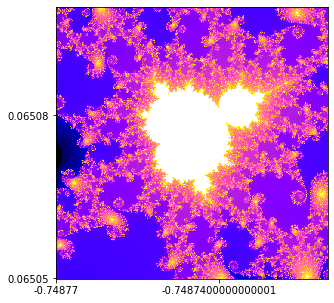

In [45]:
mandelbrot_image2(width=5,height=5,cmap='gnuplot2')

We should parallelize the top loop.  We can do it via guvectorize.

## Numba Guvectorize

Let's try guvectorize too.  It amounts to reusing the sequential code.

In [46]:
import numpy as np
from numba import jit, vectorize, guvectorize, float64, complex64, int32, float32

@jit(int32(complex64, int32))
def mandelbrot(c,maxiter):
    nreal = 0
    real = 0
    imag = 0
    for n in range(maxiter):
        nreal = real*real - imag*imag + c.real
        imag = 2* real*imag + c.imag
        real = nreal;
        if real * real + imag * imag > 4.0:
            return n
    return 0

@guvectorize([(complex64[:], int32[:], int32[:])], '(n),()->(n)',target='parallel')
def mandelbrot_numpy(c, maxit, output):
    maxiter = maxit[0]
    for i in range(c.shape[0]):
        output[i] = mandelbrot(c[i],maxiter)
        
def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    n3 = mandelbrot_numpy(c,maxiter)
    return (r1,r2,n3.T) 

### => The winner
Way faster than the sequential code compiled with Numba. 


In [47]:
%timeit mandelbrot_set(*params1[0],width=width,height=height, **params1[1])
%timeit mandelbrot_set(*params2[0],width=width,height=height, **params2[1])

7.41 ms ± 341 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
126 ms ± 2.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Check

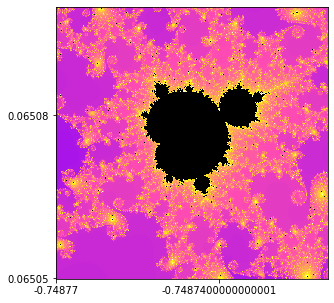

In [48]:
mandelbrot_image2(width=5,height=5,cmap='gnuplot2')

## *Why is it so fast?*

[**Numba vectorize explained**](https://numba.pydata.org/numba-doc/dev/user/vectorize.html)

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

# Bonus exercise: are we faster than pure C?
### The C code below was used by the original author (Jean Francois Puget)

```c
int mandelbrot (double creal, double cimag, int maxiter) {
  double real = creal, imag = cimag;
  int n;
  for(n = 0; n < maxiter; ++n) {
    double real2 = real*real;
    double imag2 = imag*imag;
    if (real2 + imag2 > 4.0)
      return n;
    imag = 2* real*imag + cimag;
    real = real2 - imag2 + creal;
  }
  return 0;
}

 

int* mandelbrot_set (double xmin, double xmax,
        double ymin, double ymax,
        int width, int height,
        int maxiter,
        int *output) {

  int i,j;
 
  double *xlin = (double *) malloc (width*sizeof(double));
  double *ylin = (double *) malloc (width*sizeof(double));

  double    dx = (xmax - xmin)/width;
  double    dy = (ymax - ymin)/height;

  for (i = 0; i < width; i++)
    xlin[i] = xmin + i * dx;
  for (j = 0; j < height; j++)
    ylin[j] = ymin + j * dy;
 

  for (i = 0; i < width; i++) {
    for (j = 0; j < height; j++) {
      output[i*width + j] = mandelbrot(xlin[i], ylin[j], maxiter);
    }
  }

  free(xlin);
  free(ylin);

  return output;
}
```

### The cffi magic can wrap C functions directly:

In [49]:
import cffi_magic

In [50]:
%%cffi int quint(int);
int quint(int n)
{
    return 5*n;
}

In [51]:
quint(9) # 45

45

## *Can you make it work?*
&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Code below here will not run inside the RPBS Jupyter Hub
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Let's try Cuda target.  Since there is a bug, we must pass the iteration max as an array too.

In [ ]:
import numpy as np
from numba import jit, vectorize, guvectorize, float64, complex64, int32, float32

@jit(int32(complex64, int32))
def mandelbrot(c,maxiter):
    creal = c.real
    cimag = c.imag
    real = creal
    imag = cimag
    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2* real*imag + cimag
        real = real2 - imag2 + creal
        
    return 0

@guvectorize([(complex64[:], int32[:], int32[:])], '(n),(n)->(n)', target='cuda')
def mandelbrot_numpy(c, maxit, output):
    maxiter = maxit[0]
    for i in range(c.shape[0]):
        creal = c[i].real
        cimag = c[i].imag
        real = creal
        imag = cimag
        output[i] = 0
        for n in range(maxiter):
            real2 = real*real
            imag2 = imag*imag
            if real2 + imag2 > 4.0:
                output[i] = n
                break
            imag = 2* real*imag + cimag
            real = real2 - imag2 + creal
            
        
def mandelbrot_set2(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    n3 = np.empty(c.shape, int)
    maxit = np.ones(c.shape, int) * maxiter
    n3 = mandelbrot_numpy(c,maxit)
    return (r1,r2,n3.T) 

Slightly slower.

In [ ]:
%timeit mandelbrot_set2(-2.0,0.5,-1.25,1.25,500,500,80)

In [ ]:
%timeit mandelbrot_set2(-0.74877,-0.74872,0.06505,0.06510,500,500,2048)

Check

In [ ]:
mandelbrot_set = mandelbrot_set2
mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

## TensorFlow

Code from https://www.tensorflow.org/versions/master/tutorials/mandelbrot/index.html

Timings on my machine:

5.29394221306

34.6283330917

## PyOpenCl

We reuse the boilerplate code from PyOpenCl documentation as much as possible.

In [ ]:
from __future__ import absolute_import
from __future__ import print_function

import pyopencl as cl

In [ ]:
%load_ext pyopencl.ipython_ext

We create a context interactively in order to select which device to use.

In [ ]:
ctx = cl.create_some_context(interactive=True)
devices = ctx.get_info(cl.context_info.DEVICES)
print(devices)

The code is moving the heavy duty piece to a piece of C code thta gets compiled and run on the selected device.

Input and output for that code is handled in Python.

In [ ]:
def mandelbrot_gpu(q, maxiter):

    global ctx
    
    queue = cl.CommandQueue(ctx)
    
    output = np.empty(q.shape, dtype=np.uint16)

    prg = cl.Program(ctx, """
    #pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
    __kernel void mandelbrot(__global float2 *q,
                     __global ushort *output, ushort const maxiter)
    {
        int gid = get_global_id(0);
        float nreal, real = 0;
        float imag = 0;
        output[gid] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            nreal = real*real - imag*imag + q[gid].x;
            imag = 2* real*imag + q[gid].y;
            real = nreal;
            if (real*real + imag*imag > 4.0f){
                 output[gid] = curiter;
                 break;
            }
        }
    }
    """).build()

    mf = cl.mem_flags
    q_opencl = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=q)
    output_opencl = cl.Buffer(ctx, mf.WRITE_ONLY, output.nbytes)


    prg.mandelbrot(queue, output.shape, None, q_opencl,
                   output_opencl, np.uint16(maxiter))

    cl.enqueue_copy(queue, output, output_opencl).wait()
    
    return output

def mandelbrot_set3(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    c = np.ravel(c)
    n3 = mandelbrot_gpu(c,maxiter)
    n3 = n3.reshape((width,height))
    return (r1,r2,n3.T)

Following code is faster on gpu, above code is faster on cpu.

In [ ]:
def mandelbrot_gpu(q, maxiter):

    global ctx
    
    queue = cl.CommandQueue(ctx)
    
    output = np.empty(q.shape, dtype=np.uint16)

    prg = cl.Program(ctx, """
    #pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
    __kernel void mandelbrot(__global float2 *q,
                     __global ushort *output, ushort const maxiter)
    {
        int gid = get_global_id(0);
        float real = q[gid].x;
        float imag = q[gid].y;
        output[gid] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            float real2 = real*real, imag2 = imag*imag;
            if (real*real + imag*imag > 4.0f){
                 output[gid] = curiter;
                 return;
            }
            imag = 2* real*imag + q[gid].y;
            real = real2 - imag2 + q[gid].x;
            
        }
    }
    """).build()

    mf = cl.mem_flags
    q_opencl = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=q)
    output_opencl = cl.Buffer(ctx, mf.WRITE_ONLY, output.nbytes)


    prg.mandelbrot(queue, output.shape, None, q_opencl,
                   output_opencl, np.uint16(maxiter))

    cl.enqueue_copy(queue, output, output_opencl).wait()
    
    return output

def mandelbrot_set3(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    c = np.ravel(c)
    n3 = mandelbrot_gpu(c,maxiter)
    n3 = n3.reshape((width,height))
    return (r1,r2,n3.T)

This is way faster than the rest

Let's check it is correct

In [ ]:
mandelbrot_set = mandelbrot_set3
mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

In [ ]:
mandelbrot_image(-0.74877,-0.74872,0.06505,0.06510,maxiter=2048,cmap='gnuplot2')

In [ ]:
%timeit mandelbrot_set3(-2.0,0.5,-1.25,1.25,1000,1000,80)

%timeit mandelbrot_set3(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

## PyCUDA

Modified from http://wiki.tiker.net/PyCuda/Examples/Mandelbrot

In [ ]:
import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
from pycuda.elementwise import ElementwiseKernel

complex_gpu1 = ElementwiseKernel(
    "pycuda::complex<float> *q, int *output, int maxiter",
    """
    {
        float nreal, real = 0;
        float imag = 0;
        output[i] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            nreal = real*real - imag*imag + q[i].real();
            imag = 2* real*imag + q[i].imag();
            real = nreal;
            if (real*real + imag*imag > 4.0f){
                output[i] = curiter;
                break;
                };
        };
    }
    """,
    "complex5",
    preamble="#include <pycuda-complex.hpp>",)

complex_gpu = ElementwiseKernel(
    "pycuda::complex<float> *q, int *output, int maxiter",
    """
    {
        float nreal, real = 0;
        float imag = 0;
        output[i] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            float real2 = real*real;
            float imag2 = imag*imag;
            nreal = real2 - imag2 + q[i].real();
            imag = 2* real*imag + q[i].imag();
            real = nreal;
            if (real2 + imag2 > 4.0f){
                output[i] = curiter;
                break;
                };
        };
    }
    """,
    "complex5",
    preamble="#include <pycuda-complex.hpp>",)

complex_gpu1 = ElementwiseKernel(
    "pycuda::complex<float> *q, int *output, int maxiter",
    """
    {
        float real = q[i].real();
        float imag = q[i].imag();
        output[i] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            float real2 = real*real;
            float imag2 = imag*imag;
            if (real2 + imag2 > 4.0f){
                output[i] = curiter;
                break;
            };
            imag = 2* real*imag + q[i].imag();
            real = real2 - imag2 + q[i].real();
         };
    }
    """,
    "complex5",
    preamble="#include <pycuda-complex.hpp>",)

def mandelbrot_gpu(c, maxiter):
    q_gpu = gpuarray.to_gpu(c.astype(np.complex64))
    iterations_gpu = gpuarray.to_gpu(np.empty(c.shape, dtype=np.int))
    complex_gpu(q_gpu, iterations_gpu, maxiter)

    return iterations_gpu.get()

Let's check it is correct

In [ ]:
mandelbrot_set = mandelbrot_set3
mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

In [ ]:
mandelbrot_image(-0.74877,-0.74872,0.06505,0.06510,maxiter=2048,cmap='gnuplot2')

In [ ]:
%timeit mandelbrot_set3(-2.0,0.5,-1.25,1.25,1000,1000,80)

In [ ]:
%timeit mandelbrot_set3(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

## Number of iterations

Total running time isn't the only way to look at results. Time per iteration is also interesting. We have two flavors of code, those who loop first on pixels, then on iteration of complex computation, and those who loop first on the complex iteration using array operations.  The average number of iteration is way lower in the former case.  Let's compute it.

We must be careful though, as we set to 0 the pixels that did not escape horizon.  let's use a code variant that does not do this.

In [ ]:
from numba import jit

@jit
def mandelbrot(creal,cimag,maxiter):
    real = creal
    imag = cimag
    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2* real*imag + cimag
        real = real2 - imag2 + creal       
    return maxiter


@jit
def mandelbrot_set4(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i],r2[j],maxiter)
    return (r1,r2,n3)

In [ ]:
(r1,r2,n3) = mandelbrot_set4(-2.0,0.5,-1.25,1.25,1000,1000,80)
print(n3.mean())

(r1,r2,n3) = mandelbrot_set4(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)
print(n3.mean())